In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# torchvision 数据集的输出是范围在[0,1]之间的 PILImage，我们将他们转换成归一化范围为[-1,1]之间的张量 Tensors。
transform = transforms.Compose(
    [transforms.ToTensor(), # 将图片转换为Tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   # 将图片归一化，减去均值，除以标准差

# 训练集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
# 测试集
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
# 类别信息
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


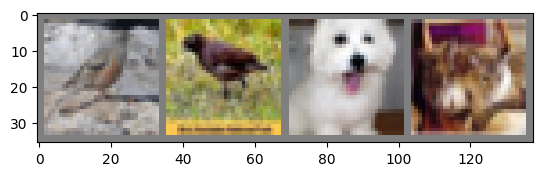

 bird  bird   dog   cat


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 显示图片的函数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取一些训练图片
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 显示图片
imshow(torchvision.utils.make_grid(images))
# 打印图片标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:

import torch.nn as nn
import torch.nn.functional as F

# 定义一个卷积神经网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
import torch.optim as optim
# 定义损失函数和优化器
# 交叉熵损失函数和随机梯度下降优化器（使用momentum）
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # SGD随机梯度下降，lr学习率，momentum动量

In [ ]:
for epoch in range(2):  # 循环遍历数据集多次
    # 每次训练一个batch
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入
        inputs, labels = data

        # 梯度清零
        optimizer.zero_grad()

        # 向前+向后+优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印统计信息
        running_loss += loss.item()
        if i % 2000 == 1999:    # 每2000个batch打印一次
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.182
[1,  4000] loss: 1.894
[1,  6000] loss: 1.685
[1,  8000] loss: 1.604
[1, 10000] loss: 1.522
[1, 12000] loss: 1.473
[2,  2000] loss: 1.399
[2,  4000] loss: 1.386
[2,  6000] loss: 1.331
[2,  8000] loss: 1.316
[2, 10000] loss: 1.300
[2, 12000] loss: 1.253
Finished Training


In [7]:
outputs = net(images)
# 返回两个张量，一个是最大值，一个是最大值的索引
# 而最大值的索引就是预测的类别
_, predicted = torch.max(outputs, 1) # 输出预测结果

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   bird horse   dog   cat


In [8]:
# 计算整个数据集的准确率
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [ ]:
# 计算每个类别的准确率
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane : 59 %
Accuracy of   car : 67 %
Accuracy of  bird : 38 %
Accuracy of   cat : 25 %
Accuracy of  deer : 41 %
Accuracy of   dog : 51 %
Accuracy of  frog : 72 %
Accuracy of horse : 68 %
Accuracy of  ship : 67 %
Accuracy of truck : 68 %


In [ ]:
# 接下来我们将讨论如何在GPU上运行神经网络。
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 确认我们的电脑支持CUDA，然后显示CUDA信息

print(device)

cpu
